# Loading and combining AMPS Netcdfs from and to a google bucket
### Another notebook for testing out methods of getting AMPS data into zarr format in our google bucket: gs://ldeo-glaciology 
We already have many AMPS netcdfs in the googlebucket https://storage.googleapis.com/ldeo-glaciology/AMPS/. 
Our aim is to combine them into an analysis-ready format.
AMPS_to_zarr.ipynb does this from local NCs.
This notebook does this from the NCs in the bucket. 

This version reads from the new version of the bucket that is not currently open for reading to everyone, so you need use the json file as a token. 

It also writes a zarr to the bucket. 

DFP: 2020-07-20

JK:  2020-08-04

In [2]:
import xarray as xr
import fsspec
import zarr
import gcsfs
import os

from dask.diagnostics import ProgressBar
#from itertools import product
#from cftime import DatetimeNoLeap
from tqdm.autonotebook import tqdm
xr.set_options(display_style="html");


### list the netcdf files

In [3]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab',
                         token='secrets/ldeo-glaciology-bc97b12df06b.json',
                         cache_timeout = 0)
NCs = fs.ls('gs://ldeo-glaciology/AMPS/wrf_d03_20161222_week-cf')


In [4]:
fs.ls('ldeo-glaciology/wrf_d03_20161222_week-cf')

['ldeo-glaciology/wrf_d03_20161222_week-cf/AMPS_test2.zarr']

### Loop through all the netcdf files in the AMPS directory and conat each one.

In [ ]:
## load the first file to inialize the xarray
url = 'gs://' + NCs[0]
with  fsspec.open(url, mode='rb', token='secrets/ldeo-glaciology-bc97b12df06b.json')  as openfile:  
    AMPS = xr.open_dataset(openfile,chunks={'south_north': 400, 'west_east': 400})  # these chunk sizes produce chunks of reasonable data volumes and which stretch through all time

## load the other files, each time concaternating them onto an xarray (AMPS) that gorws in the Time dimension each iteration. 
for i in tqdm(range(1, 54)):
    url = 'gs://' + NCs[i]
    with  fsspec.open(url, mode='rb', token='secrets/ldeo-glaciology-bc97b12df06b.json')  as openfile:  
        temp = xr.open_dataset(openfile,chunks={'south_north': 400, 'west_east': 400})  # these chunk sizes produce chunks of reasonable data volumes and which stretch through all time
    AMPS = xr.concat([AMPS,temp],'time')

### This has produced a dask array. 


In [19]:
print(AMPS.nbytes / 1e9)

1.5718532


### Write to a zarr file in the bucket

In [20]:
outfile = fsspec.get_mapper('gs://ldeo-glaciology/wrf_d03_20161222_week-cf/AMPS_test2.zarr', mode='ab',
                            token='secrets/ldeo-glaciology-bc97b12df06b.json')

In [8]:
AMPS.to_zarr(outfile, mode='w');

In [22]:
type(outfile)

fsspec.mapping.FSMap

### Read the zarr from the GCS

In [ ]:
gcsmap = gcsfs.mapping.GCSMap('gs://ldeo-glaciology/wrf_d03_20161222_week-cf/AMPS_test2.zarr', gcs=fs, check=True, create=False)

AMPS_gcs = xr.open_zarr(outfile)

### Plot a time series:
(choosing the time axis, and picking an arbitrary location in XYZ)

In [21]:
AMPS_gcs.LH.isel(south_north = 200, west_east = 300).plot(x='time')

NameError: name 'AMPS_gcs' is not defined

## Use dask to set up a larger calculation: 
 the temporal mean over the domain

In [25]:
meanLH = AMPS.LH.mean(dim='time')
meanLH

<xarray.DataArray 'LH' (south_north: 825, west_east: 537)>
dask.array<mean_agg-aggregate, shape=(825, 537), dtype=float32, chunksize=(400, 400), chunktype=numpy.ndarray>
Coordinates:
    lon      (south_north, west_east) float32 59.897705 59.80359 ... -157.98875
    lat      (south_north, west_east) float32 -80.58021 -80.60668 ... -67.988365
Dimensions without coordinates: south_north, west_east

### complete the computation

In [26]:
meanLH.compute()

<xarray.DataArray 'LH' (south_north: 825, west_east: 537)>
array([[1.152015 , 1.166457 , 1.1663514, ..., 2.680185 , 2.5820227,
        2.538653 ],
       [1.2510734, 1.14567  , 1.1625787, ..., 2.466579 , 2.3461137,
        2.381797 ],
       [1.1431516, 1.3157426, 1.1185956, ..., 2.2593842, 2.1615787,
        2.1727605],
       ...,
       [6.1832266, 7.72211  , 7.6078176, ..., 2.2511754, 2.3236778,
        2.349711 ],
       [7.8048944, 7.5382123, 7.4238997, ..., 2.2395651, 2.2354646,
        2.2842424],
       [7.93172  , 8.01044  , 7.900941 , ..., 2.5955942, 2.487265 ,
        2.534526 ]], dtype=float32)
Coordinates:
    lon      (south_north, west_east) float32 59.897705 59.80359 ... -157.98875
    lat      (south_north, west_east) float32 -80.58021 -80.60668 ... -67.988365
Dimensions without coordinates: south_north, west_east

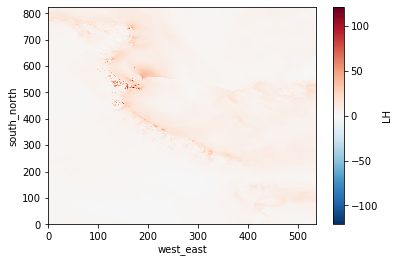

In [27]:
meanLH.plot()